## Theory
(taken from the fenics book)

We are solving the Helmholtz equation:
                       

 $$\nabla \times \frac{1}{\mu_r}\nabla \times \boldsymbol{E} - k_0^2 \epsilon_r \boldsymbol{E}=0,$$ with the boundary condition of electric mirrors.
 $$k_0 = \frac{2\pi f_0}{c_0}$$
 
 $$\epsilon_r = (n+\mathrm{i}k)^2$$

The functional is:
$$F(\boldsymbol{E}) = \frac{1}{2} \int_\Omega \left[\frac{1}{\mu_r} \left(\nabla \times \boldsymbol{E}\right)\cdot \left(\nabla \times \boldsymbol{E}\right) - k^2_0 \epsilon_r \boldsymbol{E}\boldsymbol{E}\right]dx$$

In order to find it the vector is split in to the transverse and axial components.

$$\nabla = \nabla_t + \nabla_z,$$
with $$\nabla_t = \hat{e_x}\frac{\partial}{\partial x} + \hat{e_y}\frac{\partial}{\partial y}$$
and $$\nabla_z = \hat{e_z}\frac{\partial}{\partial z}$$
We also assume that the electric field can be split like:
$$\boldsymbol{E}(x,y,z) = \left[E_t(x,y) + \hat{e_z} E_z(x,y) \right] e^{-\beta z}$$
where $\beta$ is the complex propagation constant,
$$\boldsymbol{E}_t = \hat{e_x} E_x + \hat{e_y} E_y$$ and $$ \boldsymbol{E}_{axial} = \hat{e_z} E_z$$

By splitting the $\nabla$ and by substituting the above for the electric field the functional becomes:
                               $$ F_{\beta}(\boldsymbol{E}) =  \int_{\Omega} \frac{1}{\mu_r} \left(\nabla_t \times \boldsymbol{E}_{t,\beta}\right) \cdot \left(\nabla_t \times \boldsymbol{E}_{t,\beta}\right) -k^2_0 \epsilon_r E_{t,\beta}E_{t,\beta} \\ + \beta^2 \left[\frac{1}{\mu_r} \left(\nabla_t E_z+\beta E_{t,\gamma}\right)\left(\nabla_t E_z+\beta E_{t,\gamma}\right) - k^2_0 \epsilon_r E_z E_z dx \right]$$

Since the functional is built now the electric field components need to be discetized in order to be calculated. 
The axial component can be discretised by nodal basis functions (Lagrandge) but the transverse need to be by two dimensional curl-conforming vector basis functions(Nedelec).

The electric field in the nedelec space is described by:
$$E_{t} = \sum_{i=1}^{N_{N}} (e_t)_i N_i$$

and the axial in lagrange elements as:

$$E_z = \sum_{i=1}^{N_{L}} (e_z)_i L_i$$
 Where $N_N$ and $N_L$ are the number of nedelec and lagrange elements respectively. $N_i$, $L_i$ are the basis functions and $e_t$, $e_z$ are the equivalent coefficients.

While the cuttoff method is easier to implement it only prety much finds the cuttoff wavenumber (shown in fenics book and in other papers). This is not what is of interest. I am interested in calculating the propagation constants $\beta$ and by extension the effective indices and the Electric field that they equate to.

The matrix eqution to be solved is

$$\begin{bmatrix}
    A_{tt}       & 0 \\
    0       & 0 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix} = -\beta^2
\begin{bmatrix}
    B_{tt}       & B_{tz} \\
    B_{zt}       & B_{zz} 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix}
$$

Where $$A_{tt} = S_{tt} - k^2_0 T_{tt} = \int_{\Omega} \frac{1}{\mu_r} \left(\nabla_t \times N_i \right) \left(\nabla_t \times N_j \right)dx \\ - k^2_0 \int_{\omega} \epsilon_r N_i N_jdx$$

$$B_{zz} = S_{zz} - k^2_0 T_{zz} = \int_{\Omega} \frac{1}{\mu_r} \left(\nabla_t L_i \right) \left(\nabla_t L_j \right)dx \\ - k^2_0 \int_{\omega} \epsilon_r L_i L_j dx$$

$$ B_{tt} = \int_{\Omega} \frac{1}{\mu_r} N_i \cdot  N_j dx$$

$$ B_{tz} = \int_{\Omega} \frac{1}{\mu_r} N_i \cdot  \nabla_t L_j dx$$

$$ B_{zt} = \int_{\Omega} \frac{1}{\mu_r} \nabla_t L_i \cdot  N_j dx$$

### Code
Import the required modules

In [1]:
%matplotlib inline
from __future__ import division
#from dolfin import *
import numpy as np
from scipy.constants import c,pi
from scipy.sparse.linalg import eigs, eigsh
from scipy.linalg import eig
from scipy.sparse import csr_matrix, lil_matrix, csc_matrix
import matplotlib.pylab as plt
import os
from matplotlib.colors import from_levels_and_colors
from dolfin import *
import time

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/pymodules/python2.7/petsc4py/lib/__init__.py:123: UserWarning: ignored arch: 'arch-linux2-cxx-debug', using: 'linux-gnu-c-opt'
  (os.path.pathsep.join(arch_env), arch))


The box domain:

In [2]:
a = 3e-4
b = 3e-4

Inputs of the problem

In [3]:
mu_r = 1.0 
lamda = 1.55e-6
r_core = 1e-5 # radius of core
r_clad = 10e-5 #radius of the fibre
nclad = 1.444# ref index of cladding
ncore = 1.445 # ref index of core
#neff_g = 1.4445 # Guess of the modes
num= 10   #The number of modes guess 
neff_g= ncore
mesh_refinement = 1 # number of times to uniformly refien the mesh (used for convergence plots and better results)

In [4]:
V = 2*pi/lamda*r_core*(ncore**2 - nclad**2)**0.5
print(V)

2.17882294985


In [5]:
if (nclad.imag,ncore.imag) == (0,0):
    k =0

In [6]:
k0 = 2*pi/lamda

In [7]:
def ref(x,values = np.zeros(1)):
    point = (x[0]**2+ x[1]**2)**0.5
    if  point<= r_core:
        values[0] = ncore.real**2 + ncore.imag**2
    elif point > r_core and point < r_clad:
        values[0] = nclad.real**2 + nclad.imag**2
    else:
        values[0] = 1.
    return values

def extinction(x,values = np.zeros(1)):
    point = (x[0]**2+ x[1]**2)**0.5
    if  point<= r_core:
        values[0] = ncore.imag*ncore.real
    elif point > r_core and point < r_clad:
        values[0] = nclad.imag*ncore.real
    else:
        values[0] = 0
    return values

In [8]:
x = np.linspace(-a,a,1000)
y = np.linspace(-b,b,1000)
X,Y = np.meshgrid(x,y)
n_plot = np.zeros(np.shape(X))
k_plot = np.zeros(np.shape(X))
for i,xx in enumerate(x):
    for j,yy in enumerate(y):
        n_plot[i,j] = ref([xx,yy])
        k_plot[i,j] = extinction([xx,yy])

In [9]:
cmap1, norm1 = from_levels_and_colors([1,nclad.real,ncore.real], ['red', 'blue', 'green'],extend='max')
cmap2, norm2 = from_levels_and_colors([0,nclad.imag*nclad.real,ncore.imag*ncore.real], ['red', 'blue', 'green'],extend='max')

(-0.00030000000000000003,
 0.00030000000000000003,
 -0.00030000000000000003,
 0.00030000000000000003)

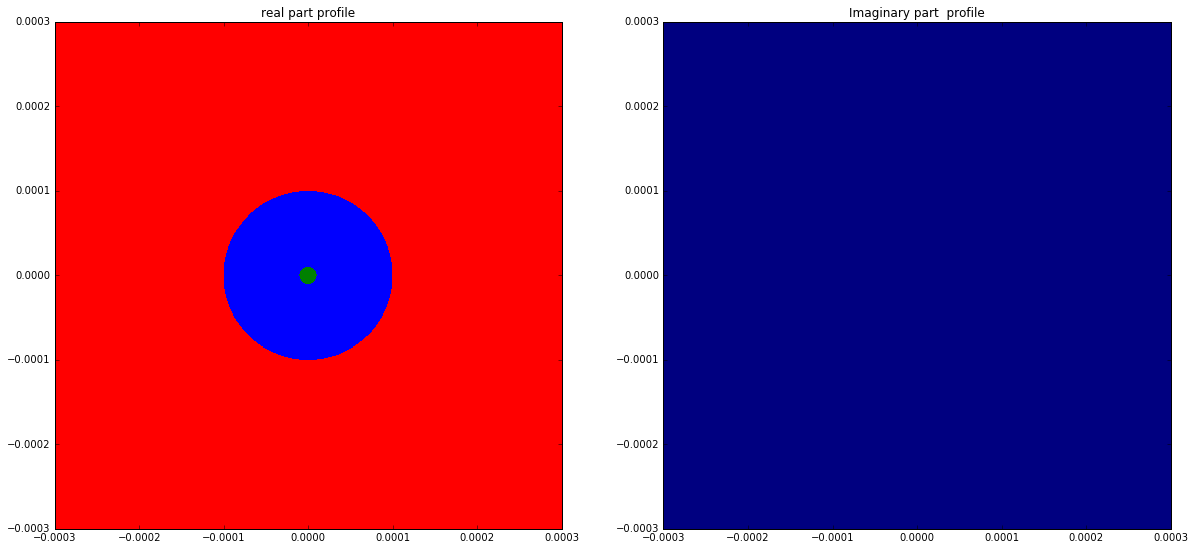

In [10]:
fig = plt.figure(figsize=(20.0, 20.0))
ax1 = fig.add_subplot(221)
ax1.pcolormesh(X,Y,n_plot**0.5, cmap=cmap1, norm=norm1)
ax1.set_title('real part profile')
ax1.axis('equal')
ax2 = fig.add_subplot(222)
ax2.pcolormesh(X,Y,k_plot)#, cmap=cmap1, norm=norm1)
ax2.set_title('Imaginary part  profile')
ax2.axis('equal')


In [11]:
class epsilon_real(Expression):
    def eval(self, values, x):
       values = ref(x,values)

class epsilon_imag(Expression):
    def eval(self, values, x):
       values = extinction(x,values)

## Mesh

Create a rectancular mesh with origin (-a,-b) extending to (a,b) or load the gmsh exported mesh

In [12]:
with open("fenics_mesh/original_geometry.geo", 'r') as content_file:
    content = content_file.readlines()

In [13]:
new_content = []
new_content.append('DefineConstant[ a = { '+str(a)+', Path "Gmsh/Parameters"}];\n')
new_content.append('DefineConstant[ b = { '+str(b)+', Path "Gmsh/Parameters"}];\n')
new_content.append('DefineConstant[ r_core = { '+str(r_core)+', Path "Gmsh/Parameters"}];\n')
new_content.append('DefineConstant[ r_clad = { '+str(r_clad)+', Path "Gmsh/Parameters"}];\n')
for i in range(4,len(content)):
    new_content.append(content[i])
with open("fenics_mesh/Output.geo", "w") as text_file:
    for i in new_content:
        text_file.write(i)

In [14]:
mesh_geom=os.popen("gmsh fenics_mesh/Output.geo -2 -o fenics_mesh/output_small.msh")
print mesh_geom.read()

Info    : Running 'gmsh fenics_mesh/Output.geo -2 -o fenics_mesh/output_small.msh' [Gmsh 2.8.3, 1 node, max. 8 threads]
Info    : Started on Tue May 10 17:26:17 2016
Info    : Reading 'fenics_mesh/Output.geo'...
Info    : Done reading 'fenics_mesh/Output.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 5 (Circle)
Info    : Meshing curve 6 (Circle)
Info    : Done meshing 1D (0 s)
Info    : Meshing 2D...
Info    : Meshing surface 11 (Plane, Delaunay)
Info    : Meshing surface 12 (Plane, Delaunay)
Info    : Meshing surface 9 (Plane, Delaunay)
Info    : Done meshing 2D (0.010186 s)
Info    : 114 vertices 257 elements
Info    : Writing 'fenics_mesh/output_small.msh'...
Info    : Done writing 'fenics_mesh/output_small.msh'
Info    : Stopped on Tue May 10 17:26:17 2016



In [15]:
refine_list = ["output_small"]
if mesh_refinement !=0:
    for i in range(mesh_refinement):
        refine_list.append("refine"+str(i+1))
    os.popen("rm fenics_mesh/refine*")
    for i in range(mesh_refinement):
        mesh_dolf = os.popen("gmsh -refine fenics_mesh/"+str(refine_list[i])+".msh -o fenics_mesh/"+str(refine_list[i+1])+'.msh')
        print mesh_dolf.read()
        time.sleep(4)

Info    : Running 'gmsh -refine fenics_mesh/output_small.msh -o fenics_mesh/refine1.msh' [Gmsh 2.8.3, 1 node, max. 8 threads]
Info    : Started on Tue May 10 17:26:17 2016
Info    : Reading 'fenics_mesh/output_small.msh'...
Info    : 114 vertices
Info    : Vertex numbering is dense
Info    : 257 elements
Info    : Done reading 'fenics_mesh/output_small.msh'
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : Meshing curve 1 order 2
Info    : Meshing curve 2 order 2
Info    : Meshing curve 3 order 2
Info    : Meshing curve 4 order 2
Info    : Meshing curve 5 order 2
Info    : Meshing curve 6 order 2
Info    : Meshing surface 9 order 2
Info    : Meshing surface 11 order 2
Info    : Meshing surface 12 order 2
Info    : Surface mesh : Worst Face Distorsion Mapping 1 Gamma 0.0750936 Nb elem. (0<d<0.2) = 0
Info    : Done meshing order 2 (0 s)
Info    : Done refining mesh (0 s)
Info    : Writing 'fenics_mesh/refine1.msh'...
Info    : Done writing 'fenics_mesh/re

In [16]:
mesh_dolf = os.popen("dolfin-convert fenics_mesh/"+refine_list[-1]+".msh fenics_mesh/fibre_small.xml")
print mesh_dolf.read()

Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 445 vertices
Found all vertices
Expecting 880 cells
Found all cells
Conversion done



In [17]:
mesh = Mesh("fenics_mesh/fibre_small.xml")
#plot(mesh,interactive=True)

## Create the function space

Define the orders of the fucntion spaces for vector and nodal basis functions

In [18]:
vector_order = 2
nodal_order = 3

Define the function spaces

In [19]:
vector_space = FunctionSpace(mesh,"Nedelec 1st kind H(curl)",vector_order)

nodal_space = FunctionSpace(mesh,"Lagrange",nodal_order)
combined_space = vector_space*nodal_space

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


Define the test and trial functions from the combined space here N_i and N_j are Nedelec basis functions and L_i and L_j are Lagrange basis functions

In [20]:
(N_i,L_i) = TestFunctions(combined_space)
(N_j,L_j) = TrialFunctions(combined_space)

## Creating the matrix equation.

$$\begin{bmatrix}
    A_{tt}       & 0 \\
    0       & 0 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix} = -\beta^2
\begin{bmatrix}
    B_{tt}       & B_{tz} \\
    B_{zt}       & B_{zz} 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix}
$$

Define the forms (matrix elements) for dispersion analysis into the basis functions

In [21]:
e_r_real = epsilon_real()
s_tt_ij = 1.0/mu_r*inner(curl(N_i),curl(N_j))
t_tt_ij = e_r_real*inner(N_i,N_j)
s_zz_ij = (1.0/mu_r) * inner(grad(L_i),grad(L_j))
t_zz_ij = e_r_real*inner(L_i,L_j)


A_tt_ij = s_tt_ij - k0**2*t_tt_ij
B_zz_ij = s_zz_ij - k0**2*t_zz_ij

B_tt_ij = 1/mu_r*inner(N_i, N_j)
B_tz_ij = 1/mu_r*inner(N_i, grad(L_j))

B_zt_ij = 1/mu_r*inner(grad(L_i),N_j)

post-multiplication by dx will result in integration over the domain of the mesh at assembly time

In [22]:
A_ij = A_tt_ij*dx
B_ij = (B_tt_ij+B_tz_ij+B_zt_ij+B_zz_ij)*dx

assemble the system Matrices. If there is loss in the system then we create a new set of matrixes and assemble them

In [23]:
A = assemble(A_ij)
B = assemble(B_ij)
####This is to try and introduce the complex part
if k !=0:
    e_r_imag = epsilon_imag()
    A_ii_complex = e_r_imag*k0**2*inner(N_i,N_j)*dx
    B_ii_complex = e_r_imag*k0**2*inner(L_i,L_j)*dx
    A_complex = assemble(A_ii_complex)
    B_complex = assemble(B_ii_complex)

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


## Implement boundary conditions

In [24]:
boundary_markers = MeshFunction('size_t',mesh,1)

mark all edges as 0

In [25]:
boundary_markers.set_all(0)

mark the edges on the boundary as 1

In [26]:
DomainBoundary().mark(boundary_markers,1)

In [27]:
electric_wall = DirichletBC(combined_space,Expression(("0.0","0.0","0.0"))
                            ,boundary_markers,1)

apply the boundary condition to the assembled matrices

In [28]:
electric_wall.apply(A)
electric_wall.apply(B)
if k!=0:
    electric_wall.apply(A_complex)
    electric_wall.apply(B_complex)

### Free the vectors and make numpy arrays to solve with scipy

initialise a vector of ones

In [29]:
indicators = np.ones(A.size(0))

get the boundary indictators to remove the rows and colums associated with the boundary DOFs

In [30]:
indicators[electric_wall.get_boundary_values().keys()]=0

the free DOFs correspond to the elements of indicators that are equal to 1

In [31]:
free_dofs = np.where(indicators == 1)[0]

In [32]:
try:
    if k!=0:
        A_np = A.array()[free_dofs,:][:,free_dofs]
        B_np = B.array()[free_dofs,:][:,free_dofs]
        A_np_complex = A_complex.array()[free_dofs,:][:,free_dofs]
        B_np_complex = B_complex.array()[free_dofs,:][:,free_dofs]
        A_np = A_np+1j*A_np_complex
        B_np = B_np+1j*B_np_complex
    else:
        A_np = A.array()[free_dofs,:][:,free_dofs]
        B_np = B.array()[free_dofs,:][:,free_dofs]
    sparse_ = False
except MemoryError:
    print "*****************The matrixes are way to large for this system.*****************"
    print "*********************The sparse Matrixes will now be tried**********************"
    sparse_ = True
    pass

In [33]:
def scipy_sparse_eigensolver(A_np_sp,B_np_sp,neff_g,num,k0):
    """
    Uses the scipy eigs to calculate the eigenvalues and eigenvectors of the equation given an effective index guess and
    the number of modes needed.
    """
    eigen_g = -neff_g**2*k0**2
    eigen2, ev2 = eigs(A_np_sp,num,B_np_sp,sigma = eigen_g,which ='LM',v0=eigen_g*np.ones(np.shape(A_np_sp)[0]))
    
    return eigen2,ev2

def scipy_eigensolver(A_np,B_np):
    eigen, ev =  eig(A_np,B_np)
    return eigen, ev

# Here is an issue that might be the cause for the eigenvalue sparse solver. The M matrix(B needs to be semi-possitive defnite matrix) dont know how to check this on the sparse matrixes. Will look.


According to the algorithm the way I set it up is:
A_np * x[i] = w[i] * B_np * x[i]

Now the problem is that since I give it the sigma (ie look around here) I need:
* 

In [34]:
def csr_creation(A,B):
    A_lil = lil_matrix((A.size(0), A.size(1)))
    B_lil = lil_matrix((B.size(0), B.size(1)))
        
    for i in range(A.size(1)):
        A_indices, A_values = A.getrow(i)
        B_indices, B_values = B.getrow(i)
        A_lil[A_indices, i] =  A_values[:, np.newaxis]
        B_lil[B_indices, i] =  B_values[:, np.newaxis]
    return A_lil.tocsr(), B_lil.tocsr()

### Solve the eigenvalue system using scipy.linalg.eig

In [35]:
sparse_ = True

In [36]:
if sparse_:
    dot_sparse = csc_matrix.dot
    A_np, B_np = csr_creation(A,B)
    if k != 0:
        A_np_complex, B_np_complex = csr_creation(A_complex,B_complex)
        A_np += 1j*A_np_complex
        B_np += 1j*B_np_complex
        del A_np_complex,B_np_complex
    A_np = A_np[free_dofs,:][:,free_dofs]
    B_np = B_np[free_dofs,:][:,free_dofs]
    print "sparse eigenvalue time"
    eigen, ev = scipy_sparse_eigensolver(dot_sparse(B_np.T,A_np),dot_sparse(B_np.T,B_np),neff_g,num,k0)
else:
    print("normal eigenvalue solver ")
    #eigen, ev = scipy_eigensolver(A_np,B_np)
    eigen, ev = scipy_eigensolver(np.dot(B_np.T,A_np),np.dot(B_np.T,B_np))

sparse eigenvalue time


Find $\beta$ from the eigenvalue.

In [37]:
beta =1j*(eigen)**0.5 
beta = np.abs(np.real(beta)) -1j*np.imag(beta)

In [38]:
beta/k0

array([ 1.44451954+0.j,  1.44450569+0.j,  1.44449562+0.j,  1.44447500+0.j,
        1.44447436+0.j,  1.44445632+0.j,  1.44444525+0.j,  1.44443362+0.j,
        1.44444139+0.j,  1.44442646+0.j])

sort the calculated values

In [39]:
sort_index = np.argsort(beta.real)[::-1]

In [40]:
first_mode_idx = 0

In [41]:
propagating_modes = np.where(((beta[sort_index]/k0).real>nclad.real) & ((beta[sort_index]/k0).real<ncore))

Print the first four effective indices. (1.4445293532400976)

In [42]:
print("The effective index of the most dominant modes are:")
print(beta[sort_index][propagating_modes]/k0)


The effective index of the most dominant modes are:
[ 1.44451954+0.j  1.44450569+0.j  1.44449562+0.j  1.44447500+0.j
  1.44447436+0.j  1.44445632+0.j  1.44444525+0.j  1.44444139+0.j
  1.44443362+0.j  1.44442646+0.j]


Use the eigenvalues/eigenvectors to release the electric field

In [43]:
def electric_field(mode_idx,x,y,k,A,ev,first_mode_idx,sort_index):
    """
    Releases the electric field from the calculated eigenvalus and eigen vectors
    
    Returns::
    E[size,size,2],E_axial(Ez)
    """

    #post-process the coefficients to map back to the full matrix
    coefficiants_global = np.zeros(A.size(0),dtype=np.complex)
    coefficiants_global[free_dofs] = ev[:,sort_index[first_mode_idx+mode_idx]]
    #Create a Function on the combined space
    mode_re = Function(combined_space)
    mode_im = Function(combined_space)
    #Assign the coefficients of the function to the calculated values
    mode_re.vector().set_local(np.real(coefficiants_global))
    mode_im.vector().set_local(np.imag(coefficiants_global))
    #Split the function into the parts in each of the functions spaces in combined_space
    #This is done using DOLFINs Function.split()
    (TE_re,TM_re) = mode_re.split()
    (TE_im,TM_im) = mode_im.split()

    E = np.zeros([len(x),len(y),2],dtype = np.complex)
    E_axial = np.zeros([len(x),len(y)], dtype= np.complex)
    for i,xx in enumerate(x):
        for j,yy in enumerate(y):
            point = Point(xx,yy)
            E[i,j,:]    =  TE_re(point) + 1j*TE_im(point)
            E_axial[i,j] = TM_re(point) + 1j*TM_im(point)
    return E,E_axial

### Plot the results

In [44]:
mode_idx = propagating_modes[0][2]
size1 = 100
size2 = 100

In [45]:
x = np.linspace(-10*r_core,10*r_core,size1)
y = np.linspace(-10*r_core,10*r_core,size2)
E,E_axial =electric_field(mode_idx,x,y,k,A,ev,first_mode_idx,sort_index)
mode_field1 = np.transpose((np.abs(E[:,:,0])**2 + np.abs(E[:,:,1])**2+np.abs(E_axial[:,:])**2)**0.5)

maxi = np.max(mode_field1)
mode_field1 /=maxi

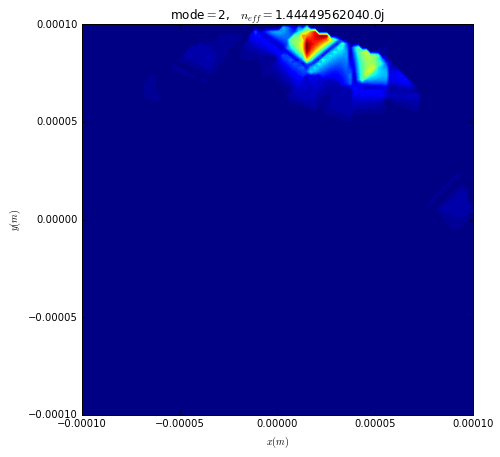

In [46]:
fig = plt.figure(figsize=(7.0, 7.0))
X,Y = np.meshgrid(x,y)
plt.contourf(X,Y,mode_field1,90)
#plt.colorbar()
#plt.axes("equal")
plt.xlabel(r'$x(m)$')
plt.ylabel(r'$y(m)$')
plt.title(r'mode$=$'+str(mode_idx)+', '+'  $n_{eff}=$'+str((beta[sort_index][mode_idx]/k0).real)+str((beta[sort_index][mode_idx]/k0).imag)+'j')
plt.show()